# MFCC / speaker prediction / LSTM

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [3]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [4]:
gender_dict = {k:v for k,v in obj}

In [5]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data

- sampling rate = 16000 Hz
- 200,000点で，200,000/16,000  = 12.5 sec
- 50 msec くらいで切りたいので，
- 50*10^-3 * 16,000 = 800 点ずつ切ればいい？
- 2の累乗にすると1024くらい？(0.064 sec)

In [6]:
import pickle
with open("mfcc_lstm_data.dump","rb") as f:
    (all_data, all_labels, all_speakers) = pickle.load(f,encoding="bytes")

In [7]:
all_data.shape

(15561, 1024)

In [8]:
all_data_label_speaker = np.array([(x,y,z) for x,y,z in zip(all_data,all_labels,all_speakers) if np.max(x)>1000.])
all_data = np.array([x for x,y,z in all_data_label_speaker])
all_labels = np.array([y for x,y,z in all_data_label_speaker])
all_speakers = np.array([z for x,y,z in all_data_label_speaker])

In [9]:
all_data.shape

(11254, 1024)

In [36]:
x_train = all_data[:10000]
y_train = np.array([r_fft(x, 16000) for x in x_train])
x_test = all_data[10000:]
y_test = np.array([r_fft(x, 16000) for x in x_test])


x_train = x_train/np.max(x_train)
y_train = y_train/np.max(y_train)
x_test = x_test/np.max(x_test)
y_test = y_test/np.max(y_test)

# s_train = all_speakers[:10000]
# s_test = all_speakers[10000:]

In [37]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10000, 1024)
(10000, 513)
(1254, 1024)
(1254, 513)


0.064 15.625
mean: -60.7080078125 std: 389.593740844 mean/std: -0.155823878692
mean: 1785.56644059 std: 10400.9289745 mean/std: 0.17167374616
161377.562294 4761.14136241 33.8947218765
max-val: 161377.562294 max-freq: 15.625 max/std: 15.515687367
mfcc shape (30, 1)
----OK----


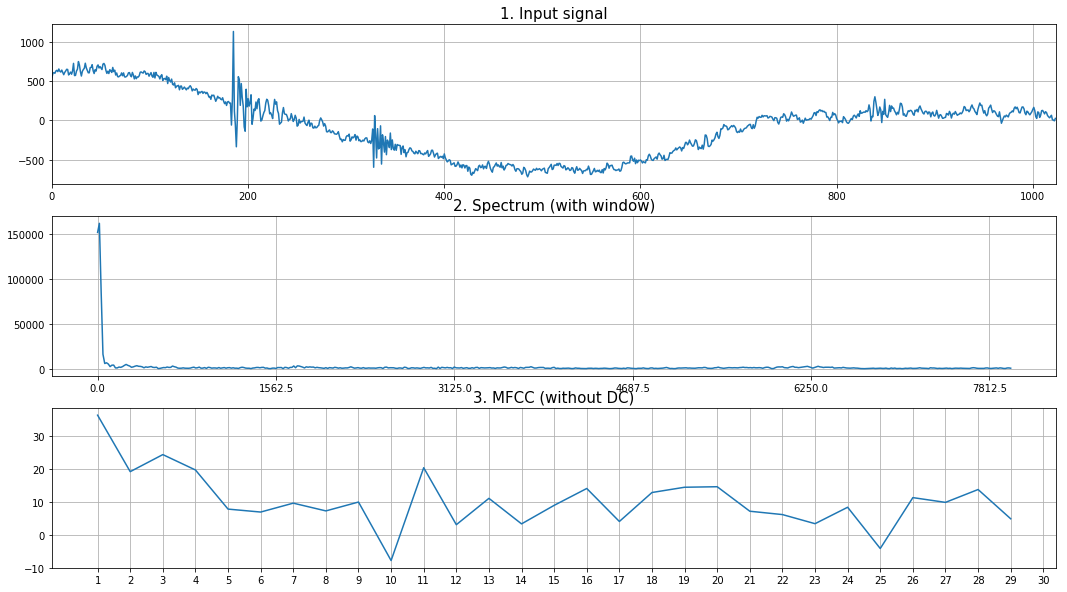

0.064 15.625
mean: 467.467773438 std: 1039.14345593 mean/std: 0.449858747383
mean: 2492.93845687 std: 19300.8299597 mean/std: 0.129162241317
288025.393387 11034.2301564 26.1028988253
max-val: 288025.393387 max-freq: 0.0 max/std: 14.9229537791
mfcc shape (30, 1)
----OK----


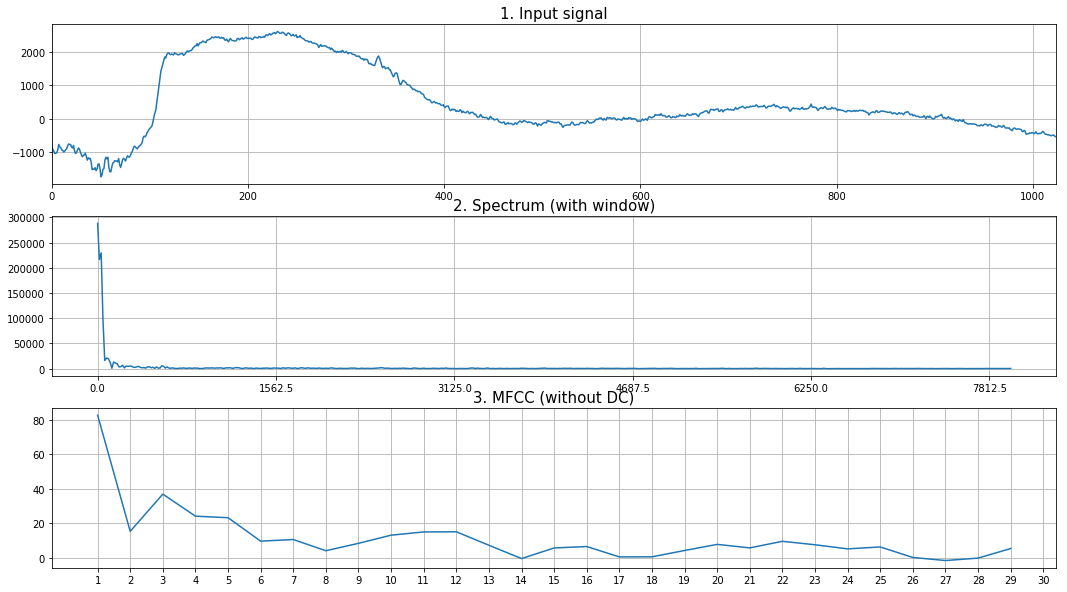

0.064 15.625
mean: 129.532226562 std: 2043.24713446 mean/std: 0.0633952811571
mean: 7624.53597648 std: 27161.7111721 mean/std: 0.280708970365
440542.041592 50236.7583995 8.76931664438
max-val: 440542.041592 max-freq: 15.625 max/std: 16.2192300331
mfcc shape (30, 1)
----OK----


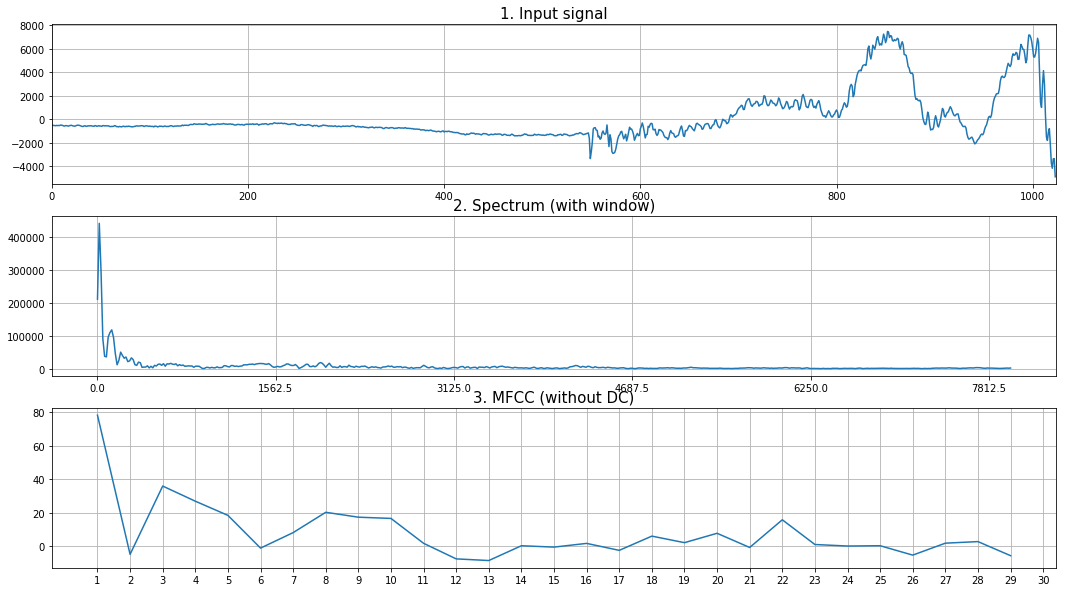

0.064 15.625
mean: -553.068359375 std: 3990.29789248 mean/std: -0.138603275815
mean: 27079.9425736 std: 75787.8138786 mean/std: 0.357312623069
780466.303797 401072.293514 1.94594918776
max-val: 780466.303797 max-freq: 15.625 max/std: 10.2980448156
mfcc shape (30, 1)
----OK----


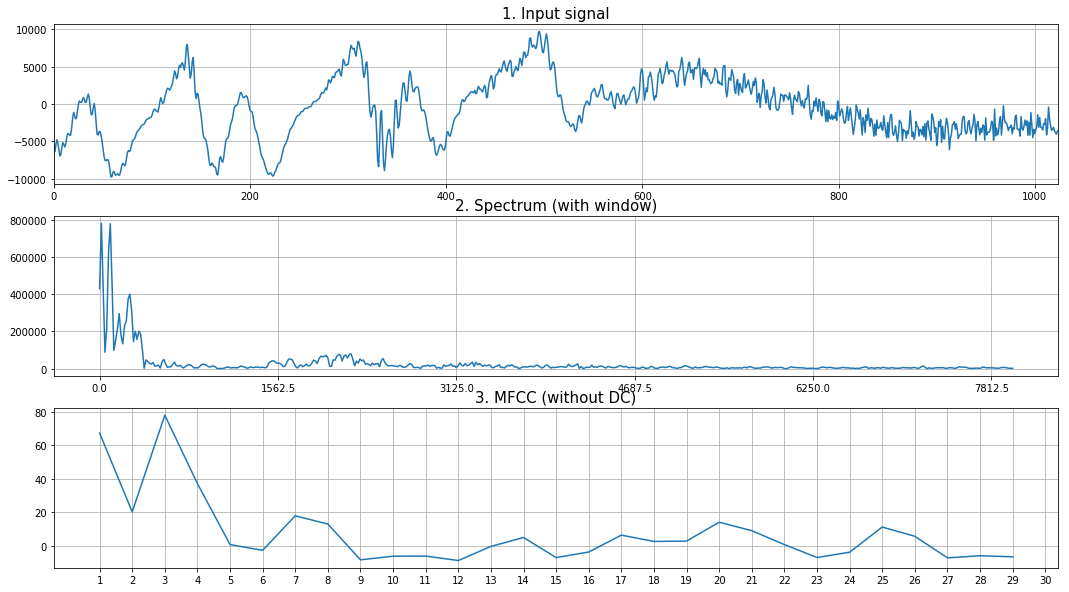

0.064 15.625
mean: -13.953125 std: 1555.94383589 mean/std: -0.00896762767274
mean: 14827.775726 std: 29382.6255322 mean/std: 0.504644341934
487083.182355 44594.5088423 10.9224923651
max-val: 487083.182355 max-freq: 15.625 max/std: 16.5772518124
mfcc shape (30, 1)
----NG----


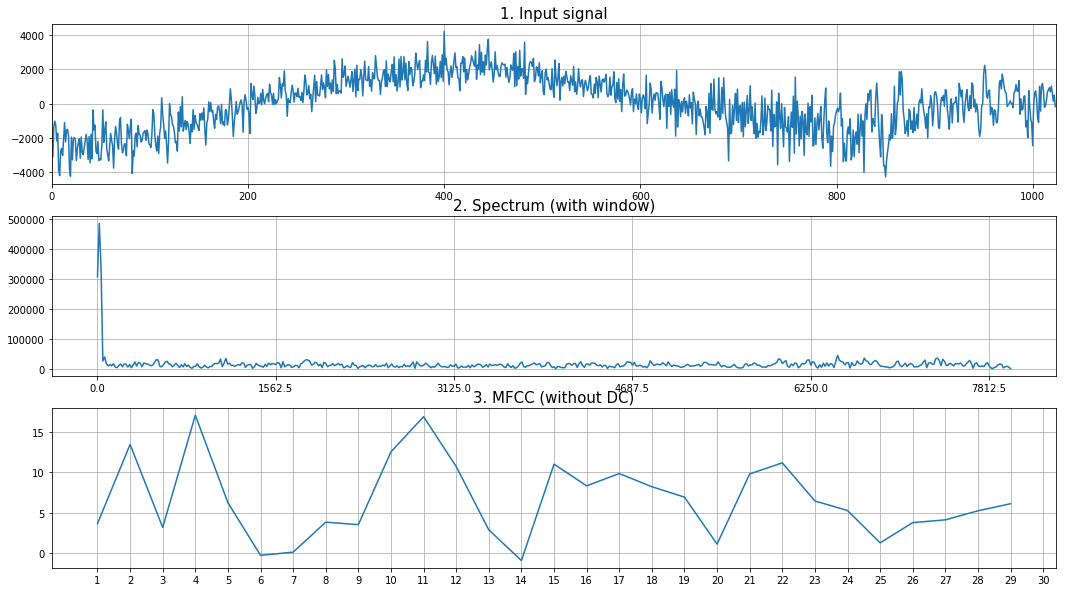

0.064 15.625
mean: -29.4443359375 std: 4565.22640766 mean/std: -0.00644969894333
mean: 30652.5570336 std: 99769.9446646 mean/std: 0.307232374807
789370.215727 731919.761654 1.07849283088
max-val: 789370.215727 max-freq: 109.375 max/std: 7.91190391435
mfcc shape (30, 1)
----OK----


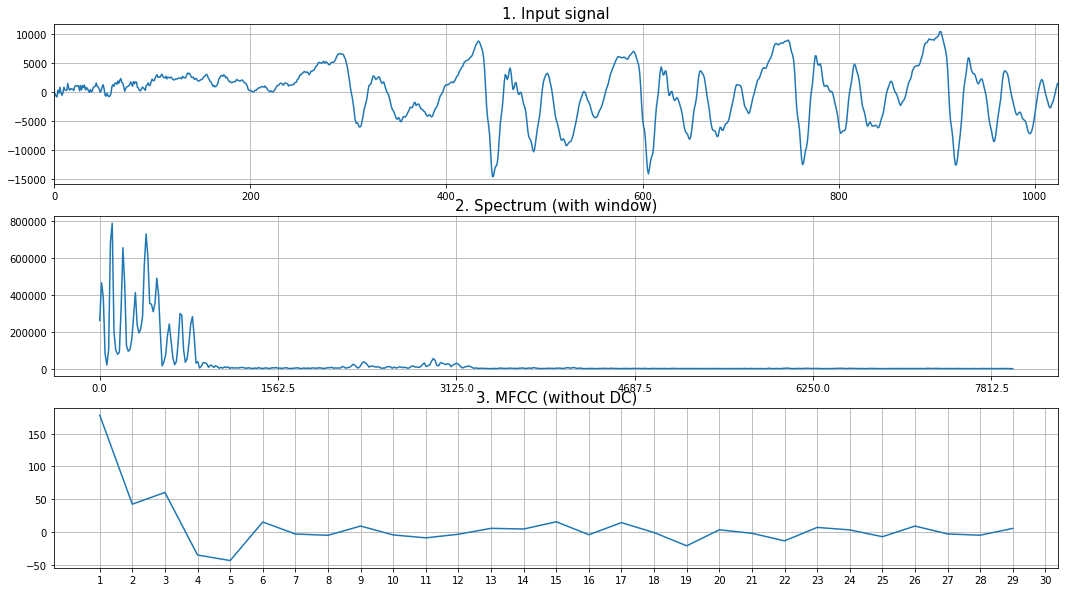

0.064 15.625
mean: 184.1328125 std: 7509.31263537 mean/std: 0.0245205948188
mean: 47192.5917688 std: 151646.907646 mean/std: 0.311200488696
1317979.91427 1341312.10669 0.98260494906
max-val: 1341312.10669 max-freq: 437.5 max/std: 8.84496840398
mfcc shape (30, 1)
----OK----


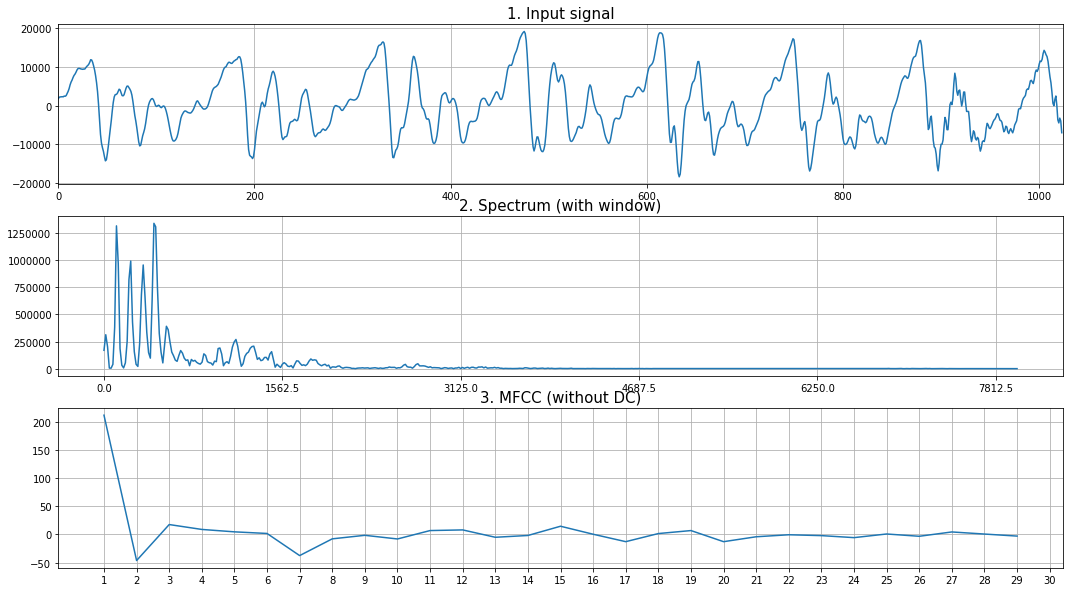

0.064 15.625
mean: -129.666992188 std: 2401.562887 mean/std: -0.053992753173
mean: 8127.79259741 std: 40318.5167219 mean/std: 0.201589573681
505986.855498 160270.259431 3.15708514664
max-val: 505986.855498 max-freq: 140.625 max/std: 12.5497388455
mfcc shape (30, 1)
----OK----


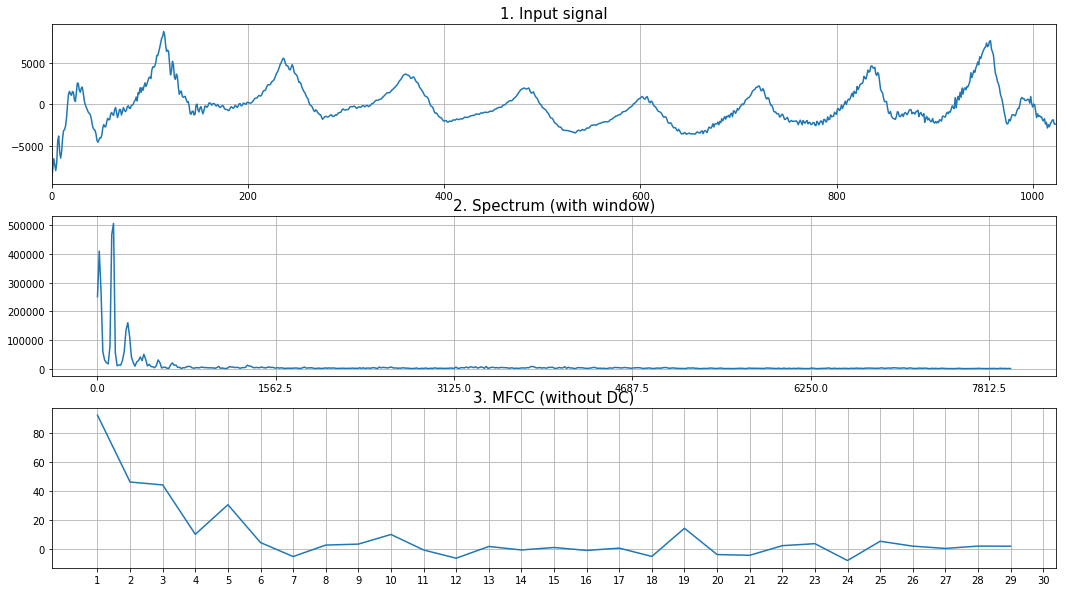

0.064 15.625
mean: 419.1640625 std: 5417.3006911 mean/std: 0.0773750778111
mean: 48710.64615 std: 83077.3430482 mean/std: 0.58632888779
988606.984759 431580.03427 2.29066895189
max-val: 988606.984759 max-freq: 125.0 max/std: 11.8998387344
mfcc shape (30, 1)
----NG----


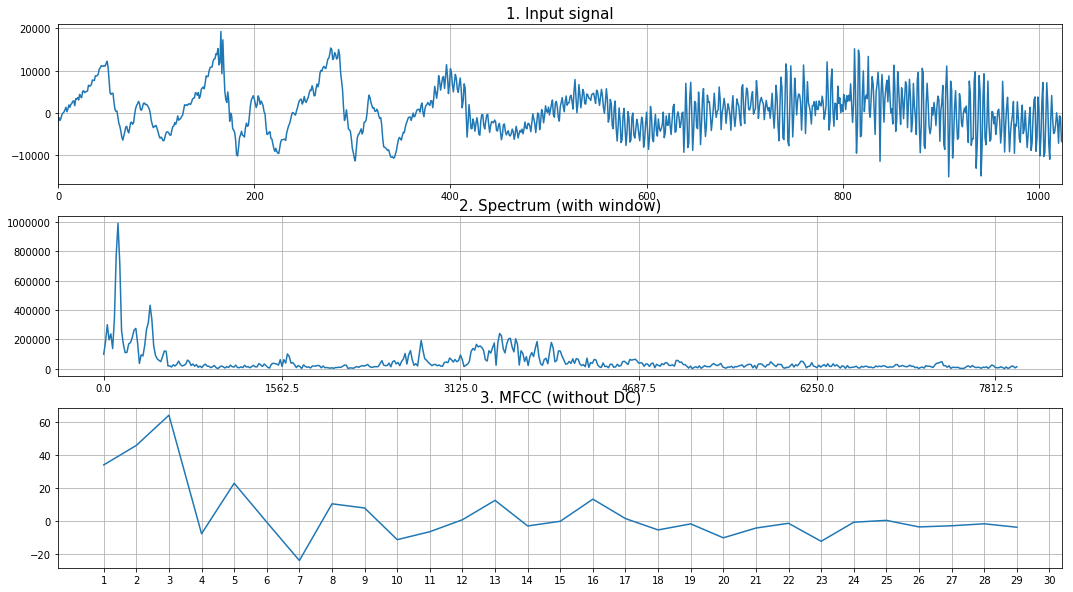

0.064 15.625
mean: -491.962890625 std: 5649.57330546 mean/std: -0.087079654343
mean: 71224.8889084 std: 93314.6613573 mean/std: 0.763276508454
143992.351641 934137.971691 0.1541446296
max-val: 934137.971691 max-freq: 3625.0 max/std: 10.0106238195
mfcc shape (30, 1)
----NG----


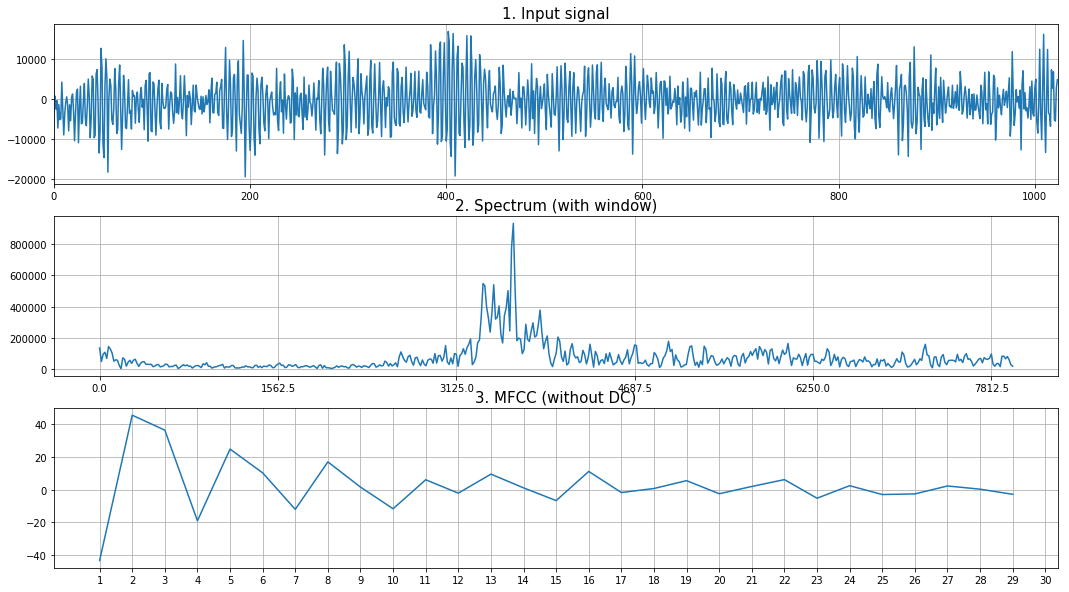

0.064 15.625
mean: 222.247070312 std: 8616.49525939 mean/std: 0.0257932098402
mean: 67567.7561958 std: 109125.136312 mean/std: 0.619176832025
998571.110456 540020.557242 1.84913536543
max-val: 998571.110456 max-freq: 125.0 max/std: 9.15069748553
mfcc shape (30, 1)
----NG----


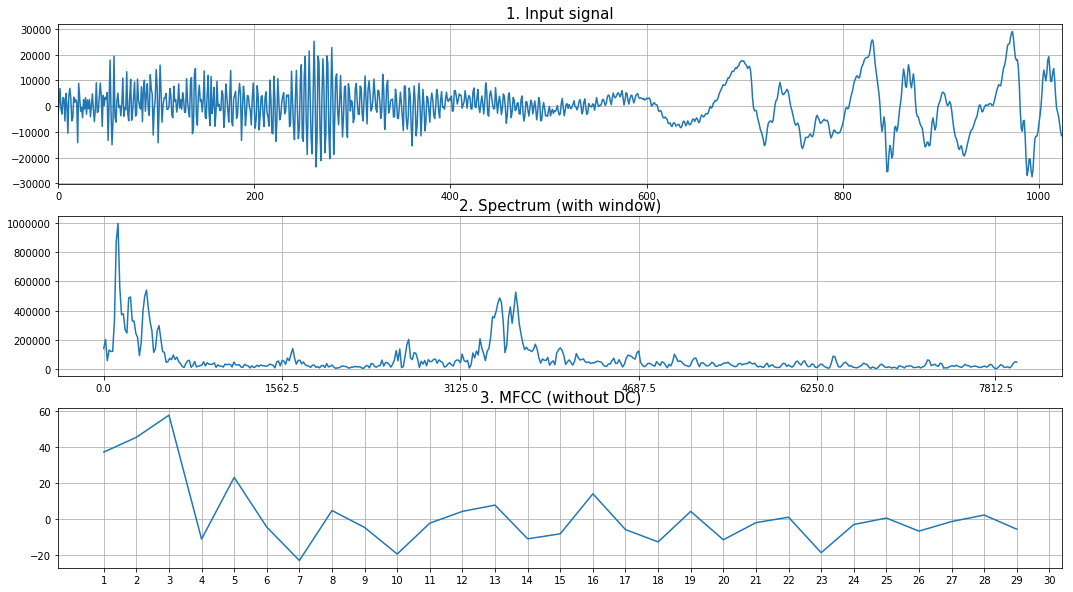

0.064 15.625
mean: 0.3154296875 std: 8603.50943163 mean/std: 3.66629094797e-05
mean: 48540.967464 std: 144012.55105 mean/std: 0.3370606736
1037293.57212 1291465.45464 0.803191110063
max-val: 1291465.45464 max-freq: 406.25 max/std: 8.96772847381
mfcc shape (30, 1)
----OK----


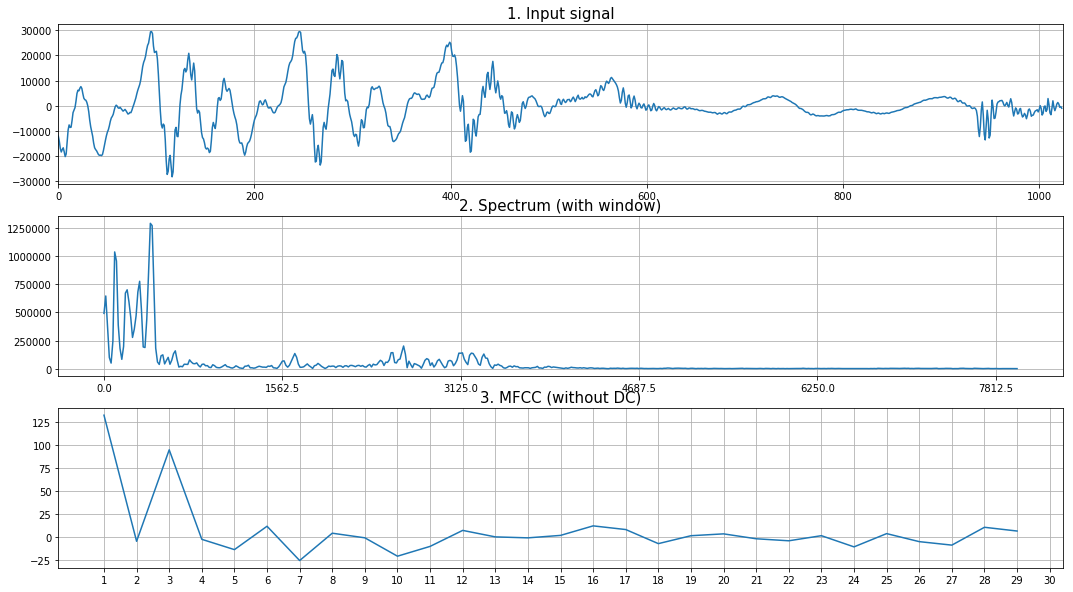

0.064 15.625
mean: -31.0625 std: 6118.25171107 mean/std: -0.00507702223885
mean: 58501.3810299 std: 128452.023574 mean/std: 0.455433705146
1006983.45308 861446.425953 1.16894495437
max-val: 1006983.45308 max-freq: 93.75 max/std: 7.83937399395
mfcc shape (30, 1)
----OK----


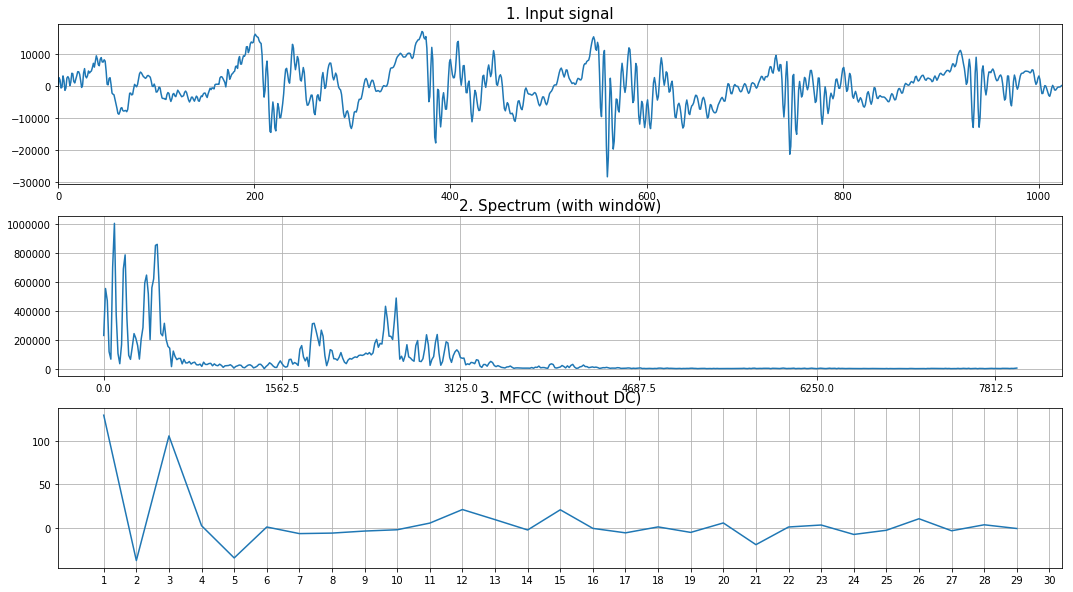

-------------------
-------------------
-------------------
0.064 15.625
mean: 8.7080078125 std: 556.0628018 mean/std: 0.0156601156997
mean: 5896.60532761 std: 6081.78642629 mean/std: 0.969551528827
62505.3705715 28574.9467491 2.18741861954
max-val: 62505.3705715 max-freq: 62.5 max/std: 10.2774688538
mfcc shape (30, 1)
----NG----


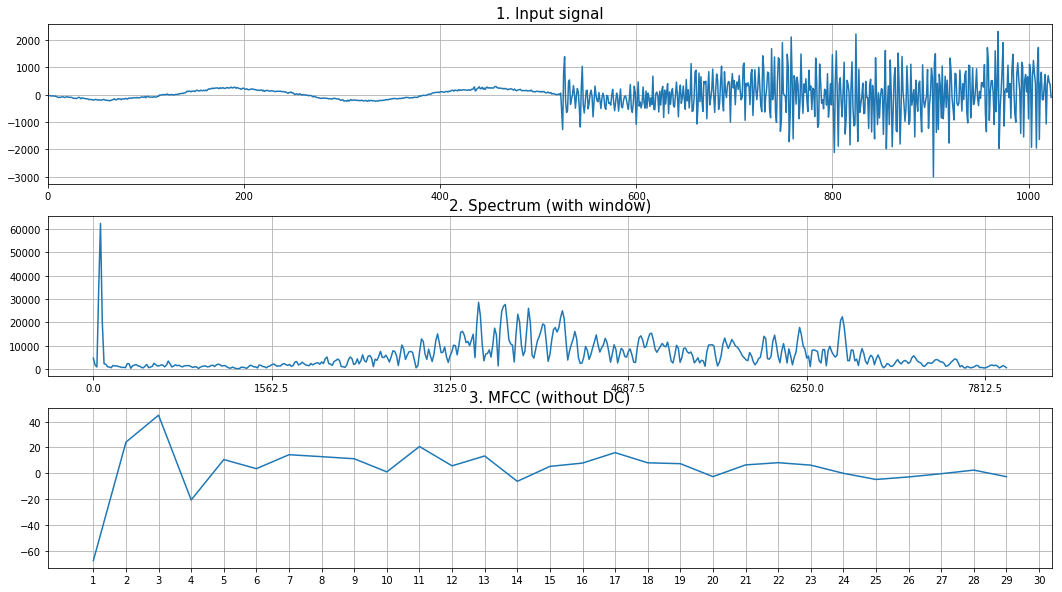

0.064 15.625
mean: 4.3828125 std: 1032.67025776 mean/std: 0.00424415486653
mean: 7765.33208215 std: 8269.85328083 mean/std: 0.93899272677
61669.0932772 57779.4502939 1.06731879524
max-val: 61669.0932772 max-freq: 62.5 max/std: 7.45709641792
mfcc shape (30, 1)
----OK----


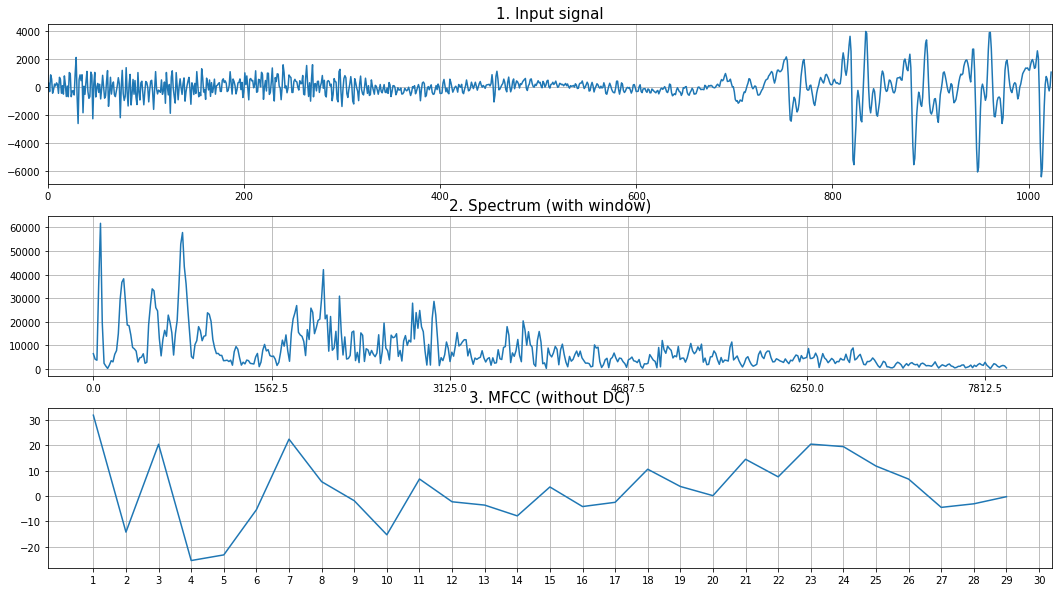

0.064 15.625
mean: 8.5703125 std: 1399.63613887 mean/std: 0.00612324322157
mean: 11683.8113027 std: 27712.5733865 mean/std: 0.421606869192
61118.6536489 225573.026193 0.270948413826
max-val: 225573.026193 max-freq: 687.5 max/std: 8.13973581761
mfcc shape (30, 1)
----OK----


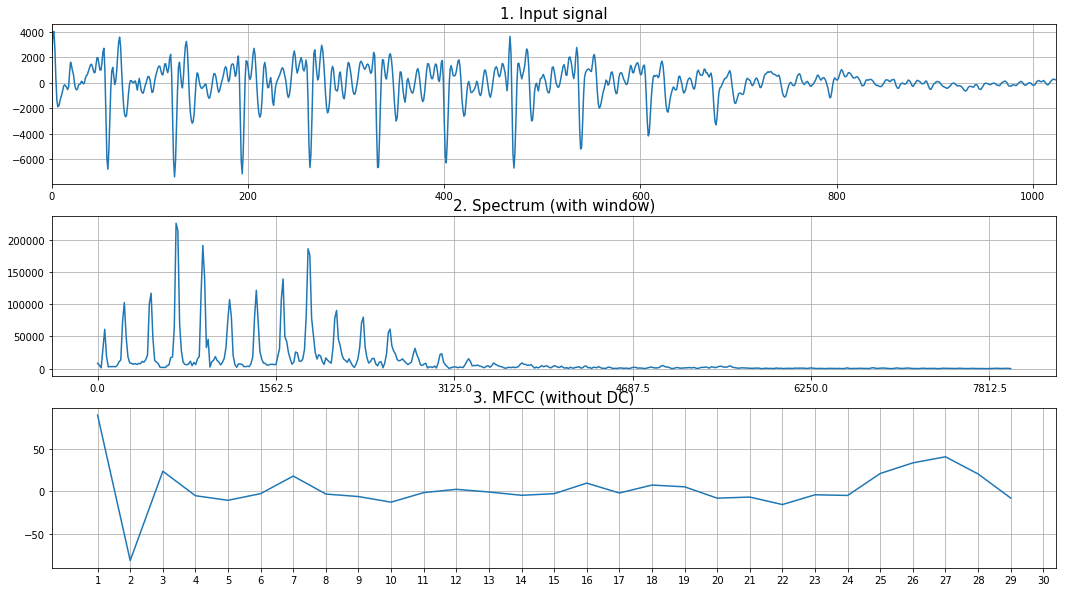

0.064 15.625
mean: 29.4130859375 std: 1248.87350423 mean/std: 0.0235516934565
mean: 12296.0668742 std: 22102.4894831 mean/std: 0.556320449041
65264.7877445 228622.438699 0.285469738298
max-val: 228622.438699 max-freq: 484.375 max/std: 10.3437415443
mfcc shape (30, 1)
----OK----


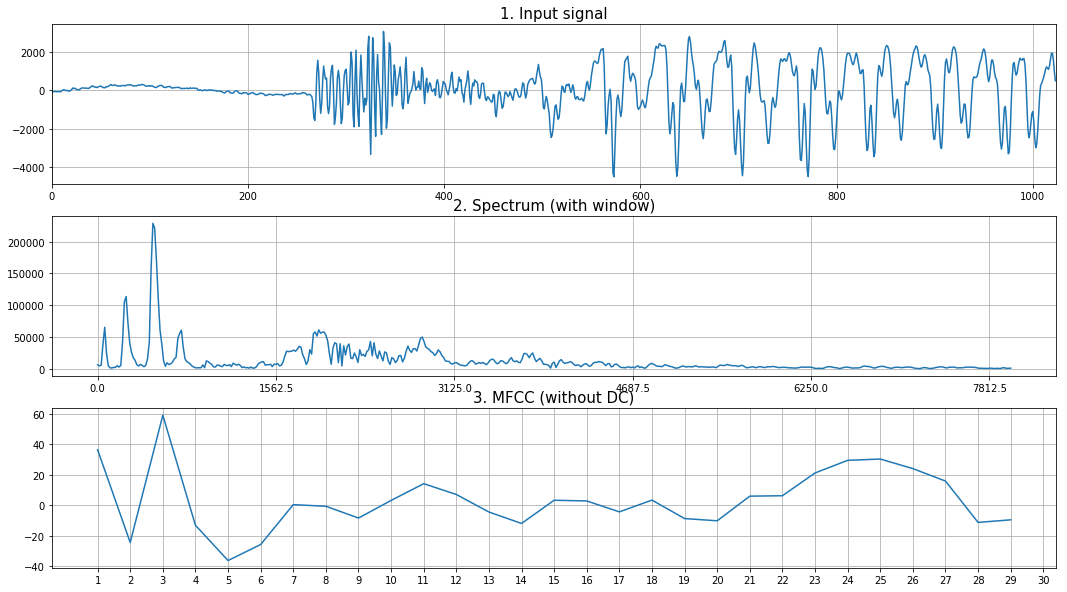

0.064 15.625
mean: 18.921875 std: 959.468798219 mean/std: 0.0197211988916
mean: 4553.65146738 std: 16938.9672773 mean/std: 0.268826982946
59026.0668695 206770.200781 0.28546699015
max-val: 206770.200781 max-freq: 437.5 max/std: 12.2067772725
mfcc shape (30, 1)
----OK----


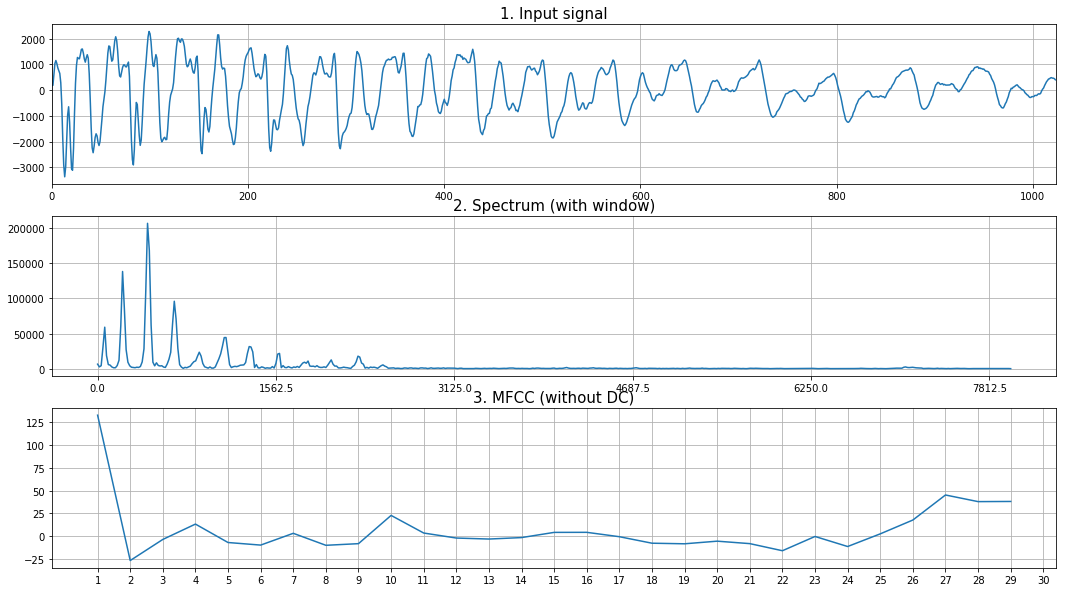

0.064 15.625
mean: 6.1943359375 std: 999.533814347 mean/std: 0.00619722499488
mean: 4928.78779497 std: 18765.4864553 mean/std: 0.26265174669
61583.3714755 185378.371249 0.332203649544
max-val: 185378.371249 max-freq: 625.0 max/std: 9.8786872214
mfcc shape (30, 1)
----OK----


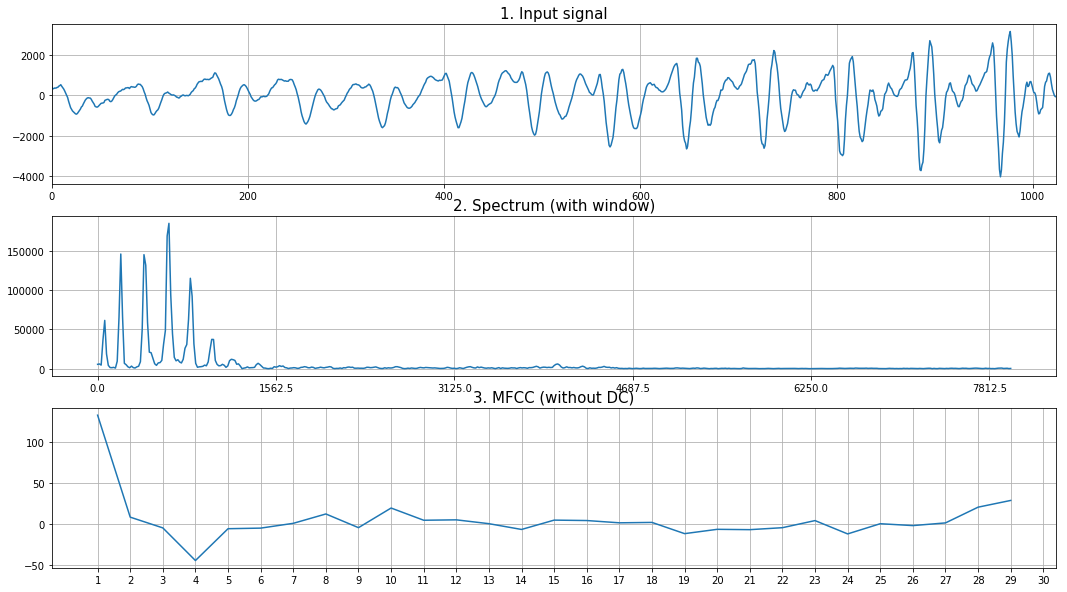

0.064 15.625
mean: 8.2333984375 std: 1359.30790755 mean/std: 0.00605705182159
mean: 14432.3820669 std: 23233.6413102 mean/std: 0.621184681048
57761.8440931 125874.723136 0.458883584042
max-val: 125874.723136 max-freq: 1328.125 max/std: 5.41777853311
mfcc shape (30, 1)
----OK----


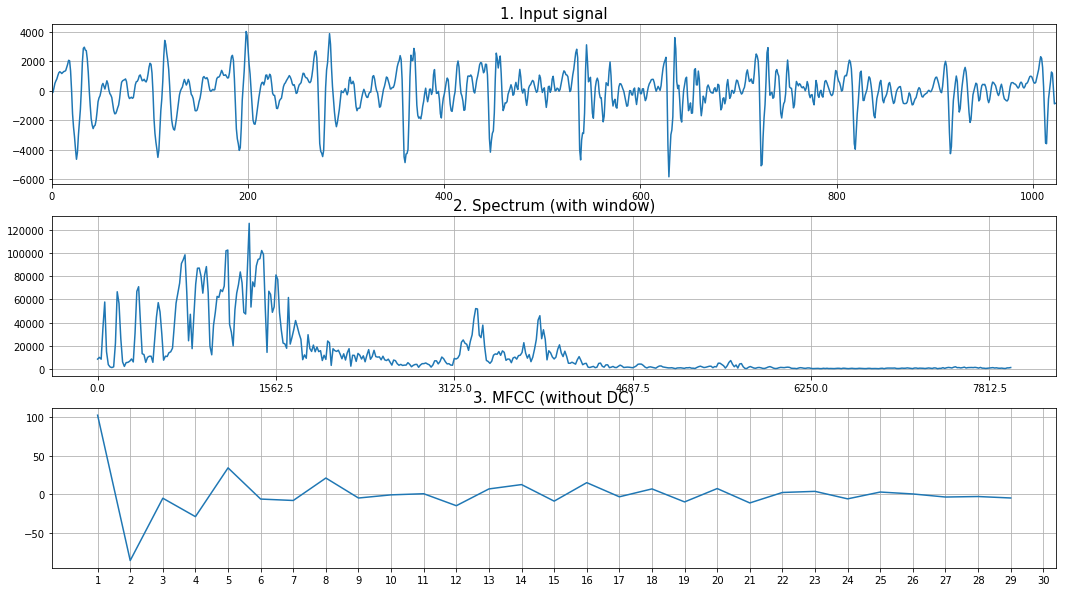

0.064 15.625
mean: 9.7978515625 std: 701.495806376 mean/std: 0.013967085011
mean: 6415.00091233 std: 13593.9356277 mean/std: 0.4719016691
56960.2223675 115857.994595 0.491638255664
max-val: 115857.994595 max-freq: 1781.25 max/std: 8.52277057715
mfcc shape (30, 1)
----OK----


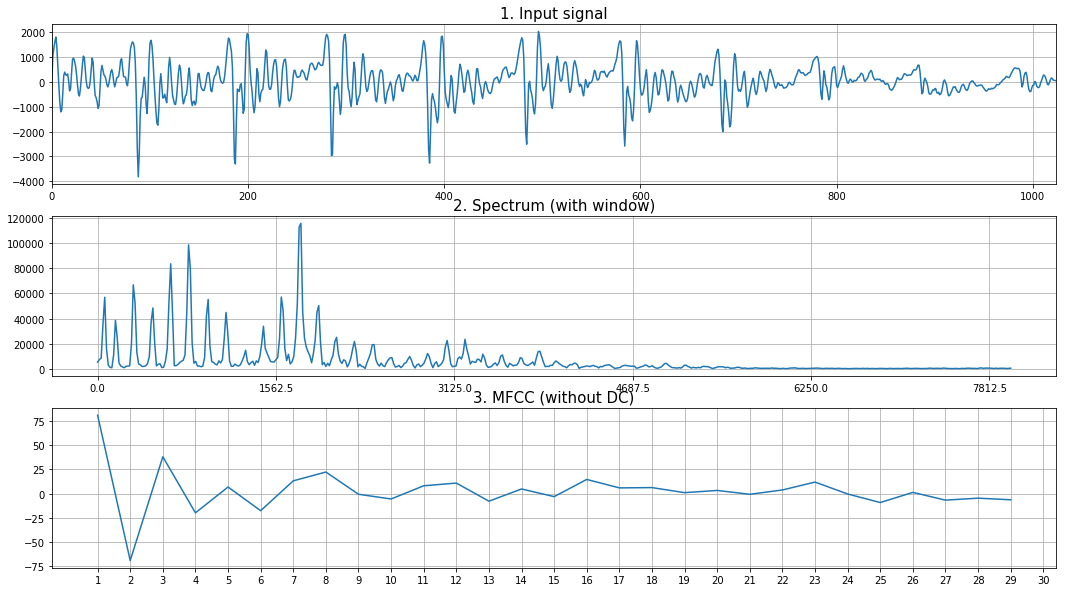

0.064 15.625
mean: 13.2548828125 std: 478.883706113 mean/std: 0.0276787091382
mean: 1559.13387037 std: 7255.33812198 mean/std: 0.214894722225
60966.7642938 92638.2702869 0.658116392987
max-val: 92638.2702869 max-freq: 218.75 max/std: 12.7682912539
mfcc shape (30, 1)
----OK----


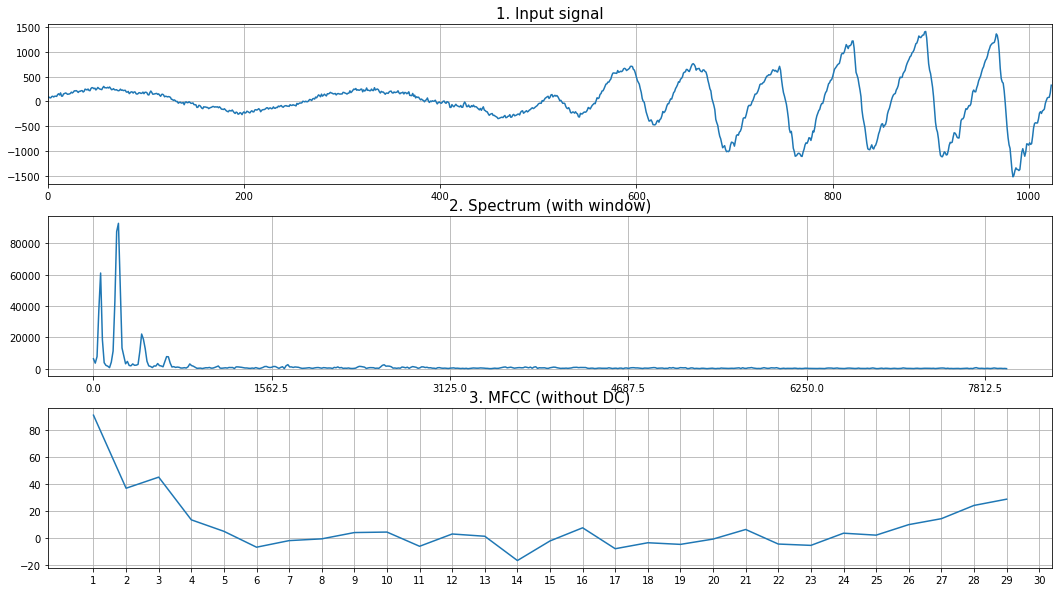

0.064 15.625
mean: 33.6494140625 std: 902.572666926 mean/std: 0.0372816674995
mean: 7154.67360364 std: 19167.9937957 mean/std: 0.373261473261
64416.1492012 237271.763763 0.271486788734
max-val: 237271.763763 max-freq: 218.75 max/std: 12.3785392614
mfcc shape (30, 1)
----OK----


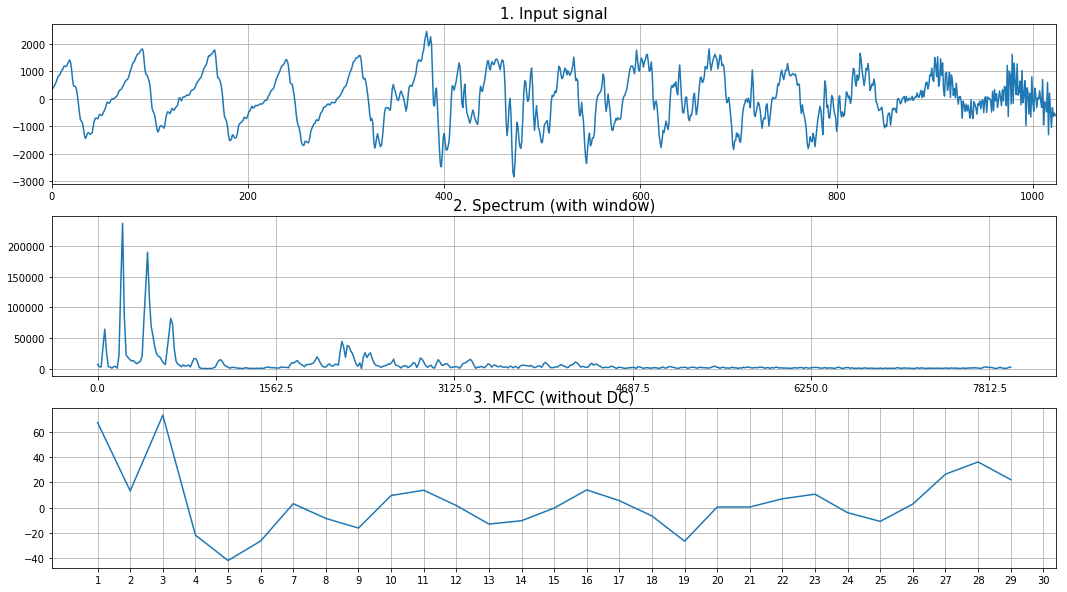

0.064 15.625
mean: 14.0244140625 std: 590.483597813 mean/std: 0.0237507258702
mean: 7541.41087653 std: 8084.07466538 mean/std: 0.932872491742
52884.1515808 40349.6150126 1.31064823206
max-val: 52884.1515808 max-freq: 62.5 max/std: 6.54176931433
mfcc shape (30, 1)
----NG----


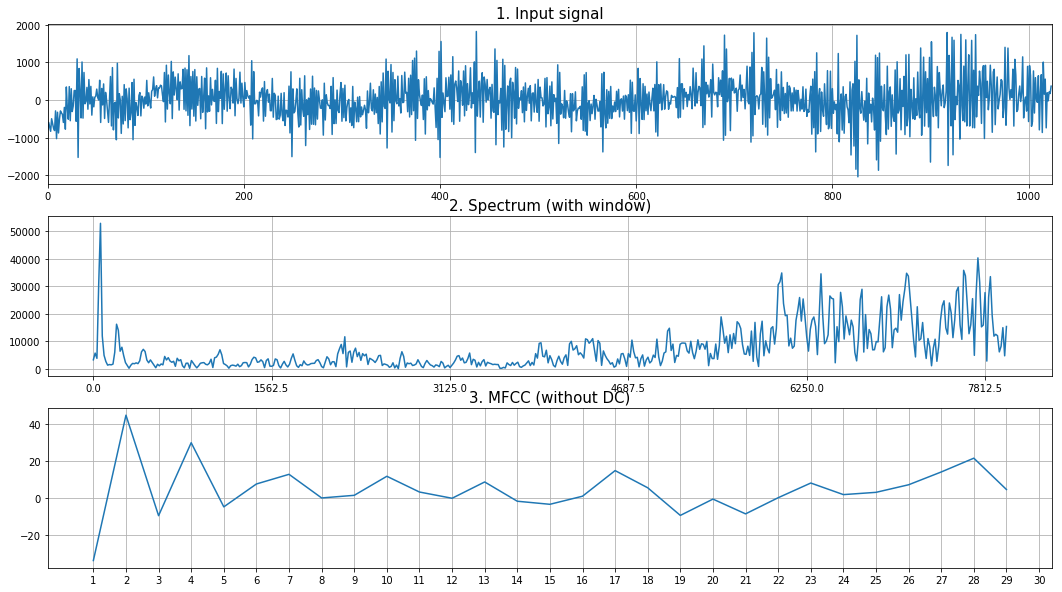

0.064 15.625
mean: 3.27734375 std: 1148.01987357 mean/std: 0.00285477963008
mean: 7334.58644609 std: 27333.8069564 mean/std: 0.268333878914
52431.4665775 400277.233971 0.130987880718
max-val: 400277.233971 max-freq: 437.5 max/std: 14.6440353007
mfcc shape (30, 1)
----OK----


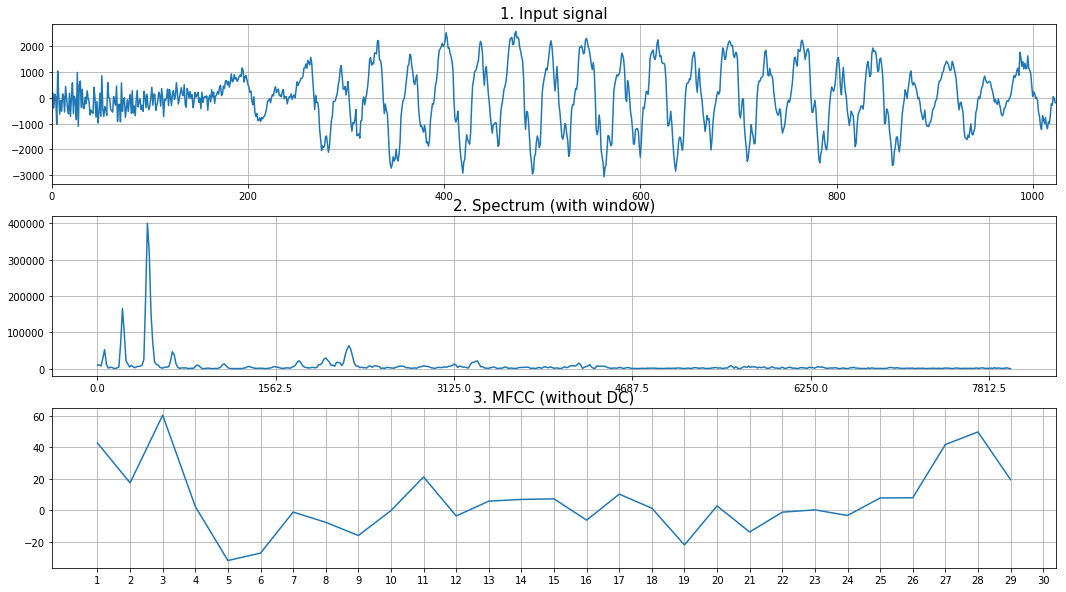

0.064 15.625
mean: 10.96875 std: 904.729033481 mean/std: 0.0121237957378
mean: 10200.2758617 std: 12915.8927789 mean/std: 0.78974609315
59790.4168728 63141.597372 0.946925946781
max-val: 63141.597372 max-freq: 5515.625 max/std: 4.88867463154
mfcc shape (30, 1)
----NG----


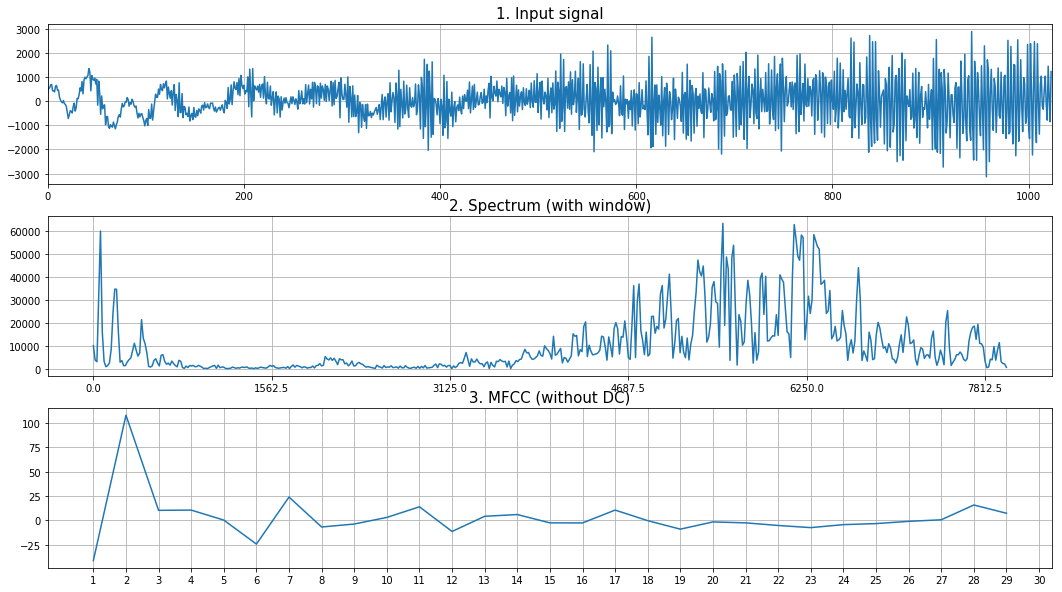

In [155]:
e = 0
for x,y in zip(x_train[500:700],y_train[500:700]):
    if y == 0:
        fft_plot(x,16000)
        e +=1
    if e>12:
        break
    
print("-------------------")
print("-------------------")
print("-------------------")
        
e = 0
for x,y in zip(x_train[:100],y_train[:100]):
    if y == 1:
        fft_plot(x,16000)
        e +=1
    if e>12:
        break
        

In [51]:
import librosa

# mfccs = librosa.feature.mfcc(x_train[0], sr=16000, hop_length=2048)

X_train = np.array([librosa.feature.mfcc(x, sr=16000, hop_length=2048) for x in x_train])
X_test = np.array([librosa.feature.mfcc(x,  sr=16000, hop_length=2048) for x in x_test])

In [38]:
x_train = x_train.reshape(-1,1024,1)
x_test = x_test.reshape(-1,1024,1)
y_train = y_train.reshape(-1,513,1)
y_test = y_test.reshape(-1,513,1)

In [39]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10000, 1024, 1)
(10000, 513, 1)
(1254, 1024, 1)
(1254, 513, 1)


In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Activation
from keras.layers import LSTM


# import numpy as np
# from keras.models import Sequential
# from keras.engine.training import _slice_arrays as slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from six.moves import range

In [41]:

%%time

#Training the model with the encoded inputs
print('Build model...')

model = Sequential()

# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
# note: in a situation where your input sequences have a variable length,
# use input_shape=(None, nb_feature).
model.add(LSTM(800, input_shape=(1024, 1)))

# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(513))

# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(1):
    model.add(LSTM(800, return_sequences=True))

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(1)))
model.add(Activation('softmax'))

model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 800)               2566400   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 513, 800)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 513, 800)          5123200   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 513, 1)            801       
_________________________________________________________________
activation_3 (Activation)    (None, 513, 1)            0         
Total params: 7,690,401
Trainable params: 7,690,401
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4.21 s, sys: 303 ms, total: 4.51 s
Wall time: 2.74 s


In [42]:
%%time

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

BATCH_SIZE = 128

# Train the model each generation and show predictions against the validation dataset
for iteration in range(1, 2):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5,
              validation_data=(x_test, y_test))
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n')
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    print('\n')


--------------------------------------------------
Iteration 1
Train on 10000 samples, validate on 1254 samples
Epoch 1/5
  128/10000 [..............................] - ETA: 12452s - loss: 0.0000e+00 - acc: 0.0000e+00

KeyboardInterrupt: 

In [56]:
num_classes = 2
batch_size = 50
epochs = 200

# LSTM model
model = Sequential()
model.inputs
model.add(LSTM(10, batch_input_shape=(50,1,1), stateful=True))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
#                     validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (50, 10)                  480       
_________________________________________________________________
dense_5 (Dense)              (50, 2)                   22        
_________________________________________________________________
activation_5 (Activation)    (50, 2)                   0         
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected lstm_5_input to have 3 dimensions, but got array with shape (15000, 20)

In [15]:
batch = X_train[:100]

In [33]:
print(batch)
a = batch.T
# print(a)
print(a[0].reshape(100,1))
print(a[0])
print(a[1])

[[  5.23621698e+02   6.10765070e+01   2.17516564e+01 ...,   4.35682249e+00
    7.42404696e+00   5.37737575e+00]
 [  5.21712362e+02   5.58368697e+01   1.62754170e+01 ...,   8.58404951e+00
    1.21203996e+01   5.19779318e+00]
 [  5.23119068e+02   6.04973779e+01   2.32900196e+01 ...,   2.55606604e+00
    3.77983209e+00   5.24913461e+00]
 ..., 
 [  5.19898810e+02   5.27121946e+01   3.03476646e+01 ...,   8.62108971e+00
   -4.87597433e-01   2.74954313e+00]
 [  6.78837468e+02   5.62037041e+01   3.34433247e+01 ...,   6.96581490e+00
    4.46360423e+00   1.44358622e+00]
 [  7.60383559e+02   6.66470685e+01  -4.34178179e+00 ...,  -7.22642441e+00
   -1.09164724e+01  -1.65150786e+01]]
[[ 523.62169752]
 [ 521.71236165]
 [ 523.11906822]
 [ 517.12001678]
 [ 517.7628195 ]
 [ 530.18234539]
 [ 539.63153169]
 [ 646.59704301]
 [ 796.40166777]
 [ 853.32652015]
 [ 630.06862957]
 [ 806.08411394]
 [ 766.059217  ]
 [ 665.2550973 ]
 [ 840.77495915]
 [ 801.08692115]
 [ 662.93097081]
 [ 666.82652592]
 [ 583.7981837

In [47]:
print('Train...')

for epoch in range(10):
    mean_tr_acc = []
    mean_tr_loss = []
    
    for i in range(int(len(X_train)/50)):
        if i%100 == 0:
            print(i*50)
        
        ind = i
        
        Y_true = Y_train[ind*50:(ind+1)*50]
        s_true = s_train[ind]
        

        batch = X_train[i*50:(i+1)*50].T
        
        for j in range(20):
            #batch 100,20,1
            mini_batch = batch[j]
            tr_loss, tr_acc = model.train_on_batch(mini_batch.reshape(50,1,1), Y_true)
#         model.reset_states()

        mean_tr_acc.append(tr_acc)
        mean_tr_loss.append(tr_loss)
        
        
    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')
    
    
#     mean_ts_acc = []
#     mean_ts_loss = []
    
#     for i in range(int(len(X_test))):
#         if i%100 == 0:
#             print(i)

#         Y_true = Y_test[i*50:(i+1)*50]
#         s_true = s_test[i]

#         batch = X_test[i*50:(i+1)*50].T
        
#         for j in range(20):
#             ts_loss, ts_acc = model.test_on_batch(batch[j].reshape(50,1,1), np.array([Y_true]))
#         model.reset_states()

#         mean_ts_acc.append(ts_acc)
#         mean_ts_loss.append(ts_loss)

# #         if s_true != 80:
# #             if s_true != s_test[i]:
# #                 model.reset_states()

#     print('accuracy testing = {}'.format(np.mean(mean_ts_acc)))
#     print('loss testing = {}'.format(np.mean(mean_ts_loss)))
#     print('___________________________________')


Train...
0
5000
10000
accuracy training = 0.43913334608078003
loss training = 9.0401029586792
___________________________________
0
5000
10000
accuracy training = 0.43913334608078003
loss training = 9.0401029586792
___________________________________
0


KeyboardInterrupt: 

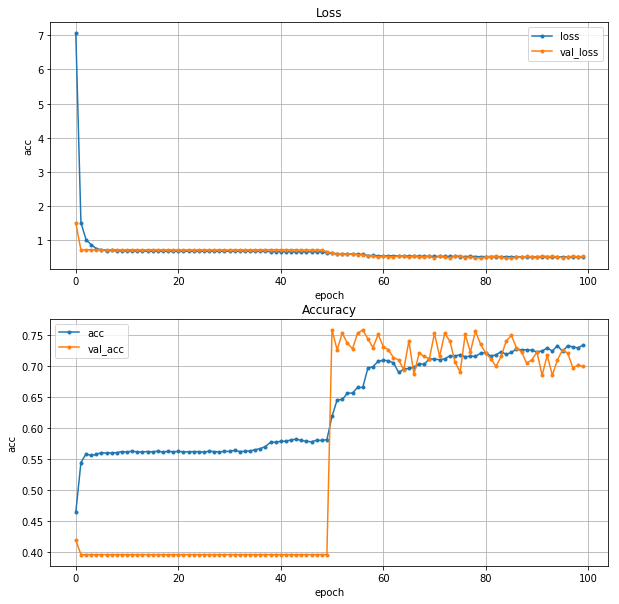

In [94]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')

In [10]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np
import librosa

def r_fft(data, fs):
    L = len(data) 
    data_length = L /fs
    delta_freq = 1/data_length

    win = hamming(L)
    
    spectrum = fft(data * win) # 窓関数あり
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    
    return half_spectrum


def fft_plot(data,fs):
    # fs = Sampling rate
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
    print(data_length,delta_freq)
    print("mean:",np.mean(data),"std:",np.std(data),"mean/std:",np.mean(data)/np.std(data))

    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum = fft(data * win) # 窓関数あり
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    mean = np.mean(half_spectrum)
    std = np.std(half_spectrum)
    max_val = np.max(half_spectrum)
    max_freq = np.argmax(half_spectrum)*delta_freq
    
    print("mean:",mean,"std:",std,"mean/std:",mean/std)
    
    print(np.max(half_spectrum[:10]),np.max(half_spectrum[10:]),np.max(half_spectrum[:10])/np.max(half_spectrum[10:]))
    print("max-val:",max_val,"max-freq:",max_freq,"max/std:",max_val/std)
    
    mfccs = mfcc(data, sr=fs, n_mfcc=30, n_fft=1024)
    print("mfcc shape",mfccs.shape)
    
    if mfccs[1] > mfccs[2]:
        print("----OK----")
    else:
        print("----NG----")

    
    # 図を表示
    fig = plt.figure(figsize=(18,10))

    fig.add_subplot(311)
    plt.plot(data)
    plt.xlim([0, L])
    plt.grid()
    plt.title("1. Input signal", fontsize = 15)

    fig.add_subplot(312)
#     plt.plot(np.arange(len(spectrum))*delta_freq, spectrum)
    plt.plot(half_spectrum)
#     plt.xlim([0, len(half_spectrum)/10])
    plt.xticks([i for i in range(len(half_spectrum))][::100],[i*delta_freq for i in range(len(half_spectrum))][::100])
    plt.grid()
    plt.title("2. Spectrum (with window)", fontsize = 15)

    fig.add_subplot(313)
    plt.plot(mfccs[1:])
    plt.xticks(np.arange(0,30),np.arange(1,31))
    plt.grid()
    plt.title("3. MFCC (without DC)", fontsize = 15)
    
    plt.show()

#     l = 512
#     data_length = l/fs
#     delta_freq = 1/data_length
#     print(data_length,delta_freq)
    
#     plt.figure(figsize=(20,10))
#     # スペクトログラムを描画
#     pxx, freqs, bins, im = plt.specgram(data, NFFT=l, Fs=fs, noverlap=0, window=hamming(l))
# #     plt.yticks(np.arange(20000)[::100],np.arange(20000)[::100]*delta_freq)
# #     plt.ylim(0,1000)
#     plt.xlabel("time [second]")
#     plt.ylabel("frequency [Hz]")

#     plt.show()
    
#     return (np.arange(len(half_spectrum))*delta_freq, half_spectrum)
    return (np.arange(len(spectrum))*delta_freq, spectrum)

In [156]:
from librosa.core import stft, spectrum
from librosa.filters import mel, dct

def mfcc(y, sr=22050, n_mfcc=20, n_fft=2048, center=False, power=2.):

    abs_spectrum = np.abs(spectrum.stft(y, n_fft=n_fft, center=False))**power

    mel_basis = mel(sr, n_fft)
    melspec = np.dot(mel_basis, abs_spectrum)

    S =spectrum.power_to_db(melspec)

    return np.dot(dct(n_mfcc, S.shape[0]), S)

